In [1]:
# We assume that PyTorch is already installed
import torch
torchversion = torch.__version__

# Install PyTorch Scatter, PyTorch Sparse, and PyTorch Geometric
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-{torchversion}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-{torchversion}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Visualization
import networkx as nx
import matplotlib.pyplot as plt

# Introduction to Graph Isomorphism Networks (GIN)

Graph Neural Networks (GNNs) have become a popular tool for tasks involving graph-structured data, such as node classification, graph classification, and link prediction. However, traditional GNNs like Graph Convolutional Networks (GCNs) have limitations in their expressive power, meaning they often struggle to distinguish between certain graph structures. **Graph Isomorphism Networks (GIN)** were proposed to address these limitations.

## Why Use GIN?

1. **Expressive Power of GIN**: GIN is theoretically as powerful as the **Weisfeiler-Lehman (WL) test**, a common algorithm for testing graph isomorphism. This means that GIN can differentiate between a larger variety of graph structures compared to other GNNs.
2. **Limitations of Other GNNs**: Popular GNNs, such as GCNs and GraphSAGE, use mean or max aggregation functions that reduce the unique information from neighboring nodes. This can cause them to map different graph structures to similar representations, failing to distinguish between them.

## Key Idea: Sum Aggregation in GIN

GIN utilizes a **sum aggregation** method for neighbor information, which is injective. This means that each unique neighborhood structure has a unique representation. By combining this with a powerful neural network model, GIN achieves a higher expressive capability than other GNNs.

### GIN Layer Formulation

Each GIN layer updates the feature vector of a node by aggregating features from its neighbors and applying a Multi-Layer Perceptron (MLP) to the result:

$$
h_v^{(k)} = \text{MLP}^{(k)} \left( (1 + \epsilon) \cdot h_v^{(k-1)} + \sum_{u \in \mathcal{N}(v)} h_u^{(k-1)} \right)
$$

- Here, $h_v^{(k)}$ is the representation of node $v$ at the $k$-th layer.
- $\mathcal{N}(v)$ represents the neighbors of $v$.
- $\epsilon$ is a learnable parameter that controls the influence of the central node in the aggregation.

By using sum aggregation and an MLP, GIN ensures that each unique graph structure has a unique embedding, thus achieving high discriminative power.

## GIN vs. GCN

In a traditional **Graph Convolutional Network (GCN)**, neighbor information is aggregated using a mean function:

$$
h_v^{(k)} = \text{ReLU} \left( W^{(k)} \cdot \text{MEAN} \left( \{ h_u^{(k-1)} | u \in \mathcal{N}(v) \cup \{ v \} \} \right) \right)
$$

While this approach works well for some tasks, it lacks the expressive power required for distinguishing complex graph structures.

## Applications of GIN

GIN is highly effective for:
- **Graph classification tasks**: Differentiating between graphs in datasets such as chemical compounds (e.g., MUTAG, PROTEINS).
- **Social network analysis**: Identifying communities or roles within social graphs where structural details are important.

## Overview of This Lab

In this lab, you will:
1. Implement a basic GIN layer using PyTorch.
2. Compare GIN with GCN on a graph classification dataset.
3. Visualize graph embeddings in 2D and 3D to see how different models represent graph structures.
4. Explore advanced topics such as mini-batching and ensemble learning with GIN.

Let's get started and dive into the code to understand GIN in practice!

### About the PROTEINS Dataset

The **PROTEINS** dataset is a popular benchmark for graph classification tasks in the field of bioinformatics. Each graph in this dataset represents a protein structure, where nodes correspond to secondary structure elements (such as helices or sheets) and edges represent spatial or sequential proximity between these elements. The classification task is to categorize each protein graph into one of two classes based on its properties. This dataset is frequently used to evaluate the performance of Graph Neural Networks (GNNs), as it requires the model to capture complex structural relationships within biological data.

In [2]:
from torch_geometric.datasets import TUDataset

dataset = TUDataset(root='.', name='PROTEINS').shuffle()

# Print information about the dataset
print(f'Dataset: {dataset}')
print('-------------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {dataset[0].x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Processing...


Dataset: PROTEINS(1113)
-------------------
Number of graphs: 1113
Number of nodes: 47
Number of features: 3
Number of classes: 2


Done!


# 3D plot

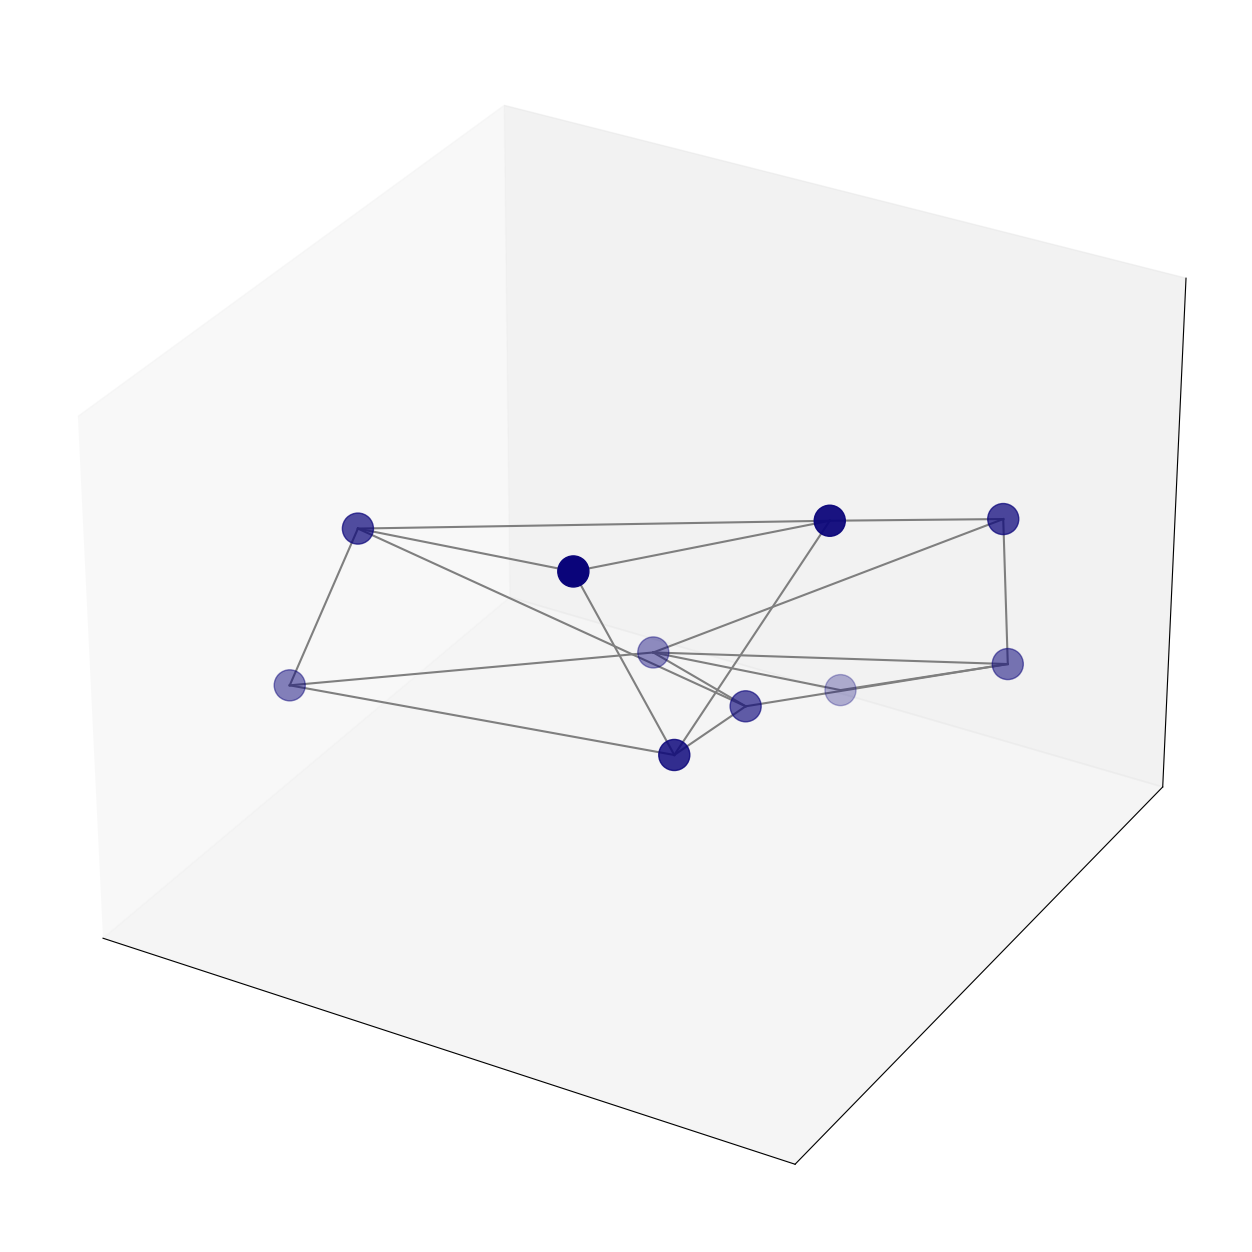

In [3]:
from torch_geometric.utils import to_networkx
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

G = to_networkx(dataset[2], to_undirected=True)

# 3D spring layout
pos = nx.spring_layout(G, dim=3, seed=0)

# Extract node and edge positions from the layout
node_xyz = np.array([pos[v] for v in sorted(G)])
edge_xyz = np.array([(pos[u], pos[v]) for u, v in G.edges()])

# Create the 3D figure
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111, projection="3d")

# Suppress tick labels
for dim in (ax.xaxis, ax.yaxis, ax.zaxis):
    dim.set_ticks([])

# Plot the nodes - alpha is scaled by "depth" automatically
ax.scatter(*node_xyz.T, s=500, c="#0A047A")

# Plot the edges
for vizedge in edge_xyz:
    ax.plot(*vizedge.T, color="tab:gray")

# fig.tight_layout()
plt.show()

# Mini-batching

In [4]:
from torch_geometric.loader import DataLoader

# Create training, validation, and test sets
train_dataset = dataset[:int(len(dataset)*0.8)]
val_dataset   = dataset[int(len(dataset)*0.8):int(len(dataset)*0.9)]
test_dataset  = dataset[int(len(dataset)*0.9):]

print(f'Training set   = {len(train_dataset)} graphs')
print(f'Validation set = {len(val_dataset)} graphs')
print(f'Test set       = {len(test_dataset)} graphs')

# Create mini-batches
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print('\nTrain loader:')
for i, subgraph in enumerate(train_loader):
    print(f' - Subgraph {i}: {subgraph}')

print('\nValidation loader:')
for i, subgraph in enumerate(val_loader):
    print(f' - Subgraph {i}: {subgraph}')

print('\nTest loader:')
for i, subgraph in enumerate(test_loader):
    print(f' - Subgraph {i}: {subgraph}')

Training set   = 890 graphs
Validation set = 111 graphs
Test set       = 112 graphs

Train loader:
 - Subgraph 0: DataBatch(edge_index=[2, 8828], x=[2291, 3], y=[64], batch=[2291], ptr=[65])
 - Subgraph 1: DataBatch(edge_index=[2, 13142], x=[3617, 3], y=[64], batch=[3617], ptr=[65])
 - Subgraph 2: DataBatch(edge_index=[2, 9624], x=[2595, 3], y=[64], batch=[2595], ptr=[65])
 - Subgraph 3: DataBatch(edge_index=[2, 8920], x=[2422, 3], y=[64], batch=[2422], ptr=[65])
 - Subgraph 4: DataBatch(edge_index=[2, 10238], x=[2686, 3], y=[64], batch=[2686], ptr=[65])
 - Subgraph 5: DataBatch(edge_index=[2, 8570], x=[2352, 3], y=[64], batch=[2352], ptr=[65])
 - Subgraph 6: DataBatch(edge_index=[2, 7932], x=[2086, 3], y=[64], batch=[2086], ptr=[65])
 - Subgraph 7: DataBatch(edge_index=[2, 7846], x=[2070, 3], y=[64], batch=[2070], ptr=[65])
 - Subgraph 8: DataBatch(edge_index=[2, 7954], x=[2104, 3], y=[64], batch=[2104], ptr=[65])
 - Subgraph 9: DataBatch(edge_index=[2, 7794], x=[1992, 3], y=[64], bat

# GIN and GCN in PyTorch Geometric

In [ ]:
from torch.nn import Linear, Sequential, BatchNorm1d, ReLU, Dropout
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GINConv
from torch_geometric.nn import global_mean_pool, global_add_pool


class GCN(torch.nn.Module):
    """GCN"""
    def __init__(self, dim_h):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(dataset.num_node_features, dim_h)
        self.conv2 = GCNConv(dim_h, dim_h)
        self.conv3 = GCNConv(dim_h, dim_h)
        self.lin = Linear(dim_h, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # Node embeddings
        h = self.conv1(x, edge_index)
        h = h.relu()
        h = self.conv2(h, edge_index)
        h = h.relu()
        h = self.conv3(h, edge_index)

        # Graph-level readout
        hG = global_mean_pool(h, batch)

        # Classifier
        h = F.dropout(hG, p=0.5, training=self.training)
        h = self.lin(h)

        return hG, F.log_softmax(h, dim=1)

### Building a Graph Isomorphism Network (GIN) Model: Theoretical Foundations and Design Choices

In this section, we’ll design a Graph Isomorphism Network (GIN) model for graph classification. we'll explore the key ideas behind each design choice.

   - At the core of GIN is a **GIN convolutional layer** that aggregates information from each node’s neighbors. A GIN layer uses a Multi-Layer Perceptron (MLP) to transform aggregated features, making it powerful enough to capture complex patterns in node neighborhoods.
   - The MLP typically includes several linear transformations and non-linearities (e.g., ReLU activations). **Why might we want to add Batch Normalization** here? Consider how it might help with stable learning.

#### 2. **Stacking Multiple GIN Layers**
   - GIN models often use multiple GIN layers to progressively capture information from nodes farther away in the graph. With each layer, the receptive field of each node expands, allowing the model to incorporate broader structural information.
   - Think about **how many GIN layers** would be ideal for your model. What might be the trade-offs between more layers versus fewer layers?

#### 3. **Pooling for Graph-Level Readout**
   - Since GIN is designed to classify entire graphs, we need a way to aggregate the node embeddings into a single representation for each graph. This process is called **graph-level pooling**.
   - One effective pooling method is to **sum up the embeddings of all nodes** in the graph (often called `global_add_pool`). This sum-based aggregation helps preserve the structural uniqueness of each graph, aligning with the theoretical strengths of GIN.
   - Consider the possibility of pooling the outputs of each GIN layer separately (for example, pooling after each layer in a multi-layer model) to retain information from different aggregation depths.

#### 4. **Concatenating Graph Embeddings from Each Layer**
   - If we perform pooling after each GIN layer, we end up with graph embeddings at multiple stages of aggregation. By **concatenating these embeddings**, we can capture features at various levels of detail in a single representation.
   - Reflect on why concatenating embeddings might make the model more expressive and how this approach could affect classification performance.

#### 5. **Final Classifier**
   - After obtaining the final graph-level embedding, a fully connected network can be used to classify the graph. Typically, this includes one or two linear layers, with optional dropout and activation functions to prevent overfitting and enhance learning capacity.
   - Think about the role of **dropout** in this final classifier and why it might be essential, especially when training on small datasets.

#### Implementation Challenge
Based on these design principles, construct your GIN model using PyTorch Geometric. Experiment with:
- Different numbers of GIN layers
- Various configurations within each GIN layer, such as the number of hidden units in the MLP and whether to include Batch Normalization
- Pooling approaches (try pooling at different layers or testing alternative pooling functions)

These choices will influence your model’s performance on the graph classification task. Once you’ve completed your implementation, observe the impact of your design decisions on the model's accuracy and generalization.

In [ ]:
class GIN(torch.nn.Module):
    """GIN"""
    def __init__(self, dim_h):
        super(GIN, self).__init__()
        ...

    def forward(self, x, edge_index, batch):
        ...

        return h, F.log_softmax(h, dim=1)

gcn = GCN(dim_h=32)
gin = GIN(dim_h=32)

# Train

In [6]:
def train(model, loader):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),
                                      lr=0.01,
                                      weight_decay=0.01)
    epochs = 100

    model.train()
    for epoch in range(epochs+1):
      total_loss = 0
      acc = 0
      val_loss = 0
      val_acc = 0

      # Train on batches
      for data in loader:
        optimizer.zero_grad()
        _, out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y)
        total_loss += loss / len(loader)
        acc += accuracy(out.argmax(dim=1), data.y) / len(loader)
        loss.backward()
        optimizer.step()

        # Validation
        val_loss, val_acc = test(model, val_loader)

    # Print metrics every 10 epochs
    if(epoch % 10 == 0):
        print(f'Epoch {epoch:>3} | Train Loss: {total_loss:.2f} '
              f'| Train Acc: {acc*100:>5.2f}% '
              f'| Val Loss: {val_loss:.2f} '
              f'| Val Acc: {val_acc*100:.2f}%')

    test_loss, test_acc = test(model, test_loader)
    print(f'Test Loss: {test_loss:.2f} | Test Acc: {test_acc*100:.2f}%')

    return model

def test(model, loader):
    criterion = torch.nn.CrossEntropyLoss()
    model.eval()
    loss = 0
    acc = 0

    for data in loader:
      _, out = model(data.x, data.edge_index, data.batch)
      loss += criterion(out, data.y) / len(loader)
      acc += accuracy(out.argmax(dim=1), data.y) / len(loader)

    return loss, acc

def accuracy(pred_y, y):
    """Calculate accuracy."""
    return ((pred_y == y).sum() / len(y)).item()

gcn = train(gcn, train_loader)
gin = train(gin, train_loader)

Epoch 100 | Train Loss: 0.68 | Train Acc: 59.06% | Val Loss: 0.67 | Val Acc: 61.39%
Test Loss: 0.66 | Test Acc: 62.76%
Epoch 100 | Train Loss: 0.51 | Train Acc: 77.21% | Val Loss: 0.50 | Val Acc: 80.55%
Test Loss: 0.58 | Test Acc: 67.71%


# Plot graph classification

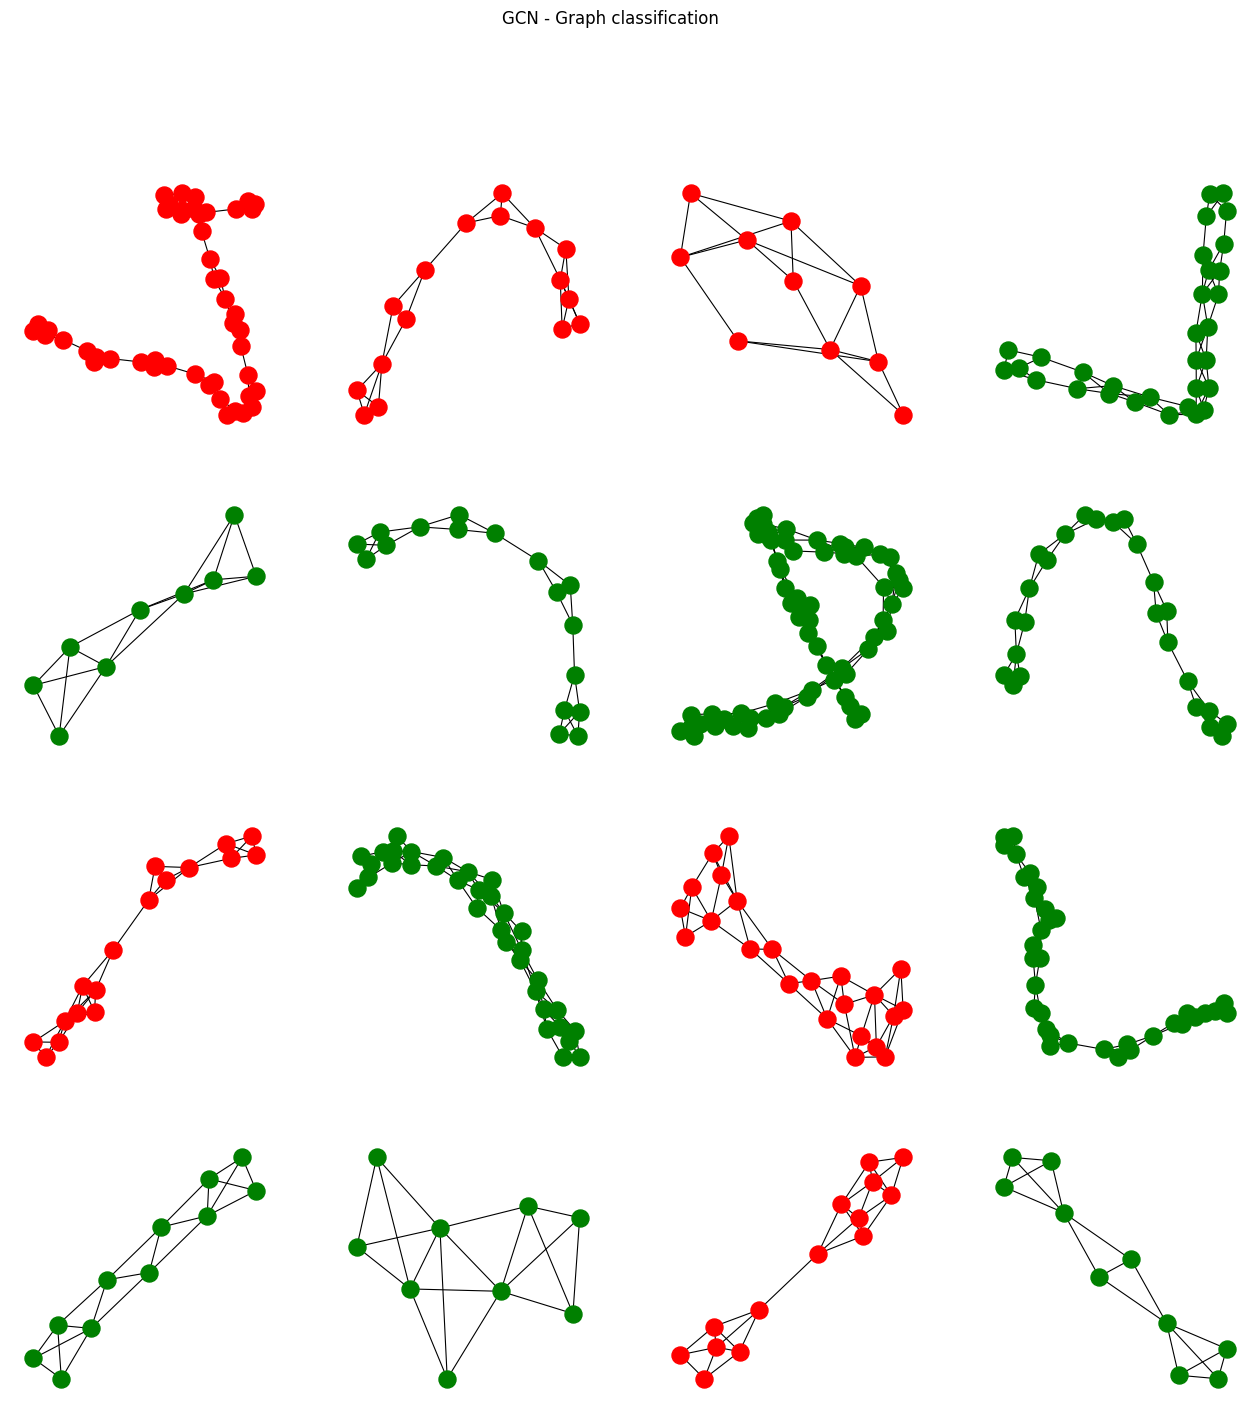

In [7]:
fig, ax = plt.subplots(4, 4, figsize=(16,16))
fig.suptitle('GCN - Graph classification')

for i, data in enumerate(dataset[1113-16:]):
    # Calculate color (green if correct, red otherwise)
    _, out = gcn(data.x, data.edge_index, data.batch)
    color = "green" if out.argmax(dim=1) == data.y else "red"

    # Plot graph
    ix = np.unravel_index(i, ax.shape)
    ax[ix].axis('off')
    G = to_networkx(dataset[i], to_undirected=True)
    nx.draw_networkx(G,
                    pos=nx.spring_layout(G, seed=0),
                    with_labels=False,
                    node_size=150,
                    node_color=color,
                    width=0.8,
                    ax=ax[ix]
                    )

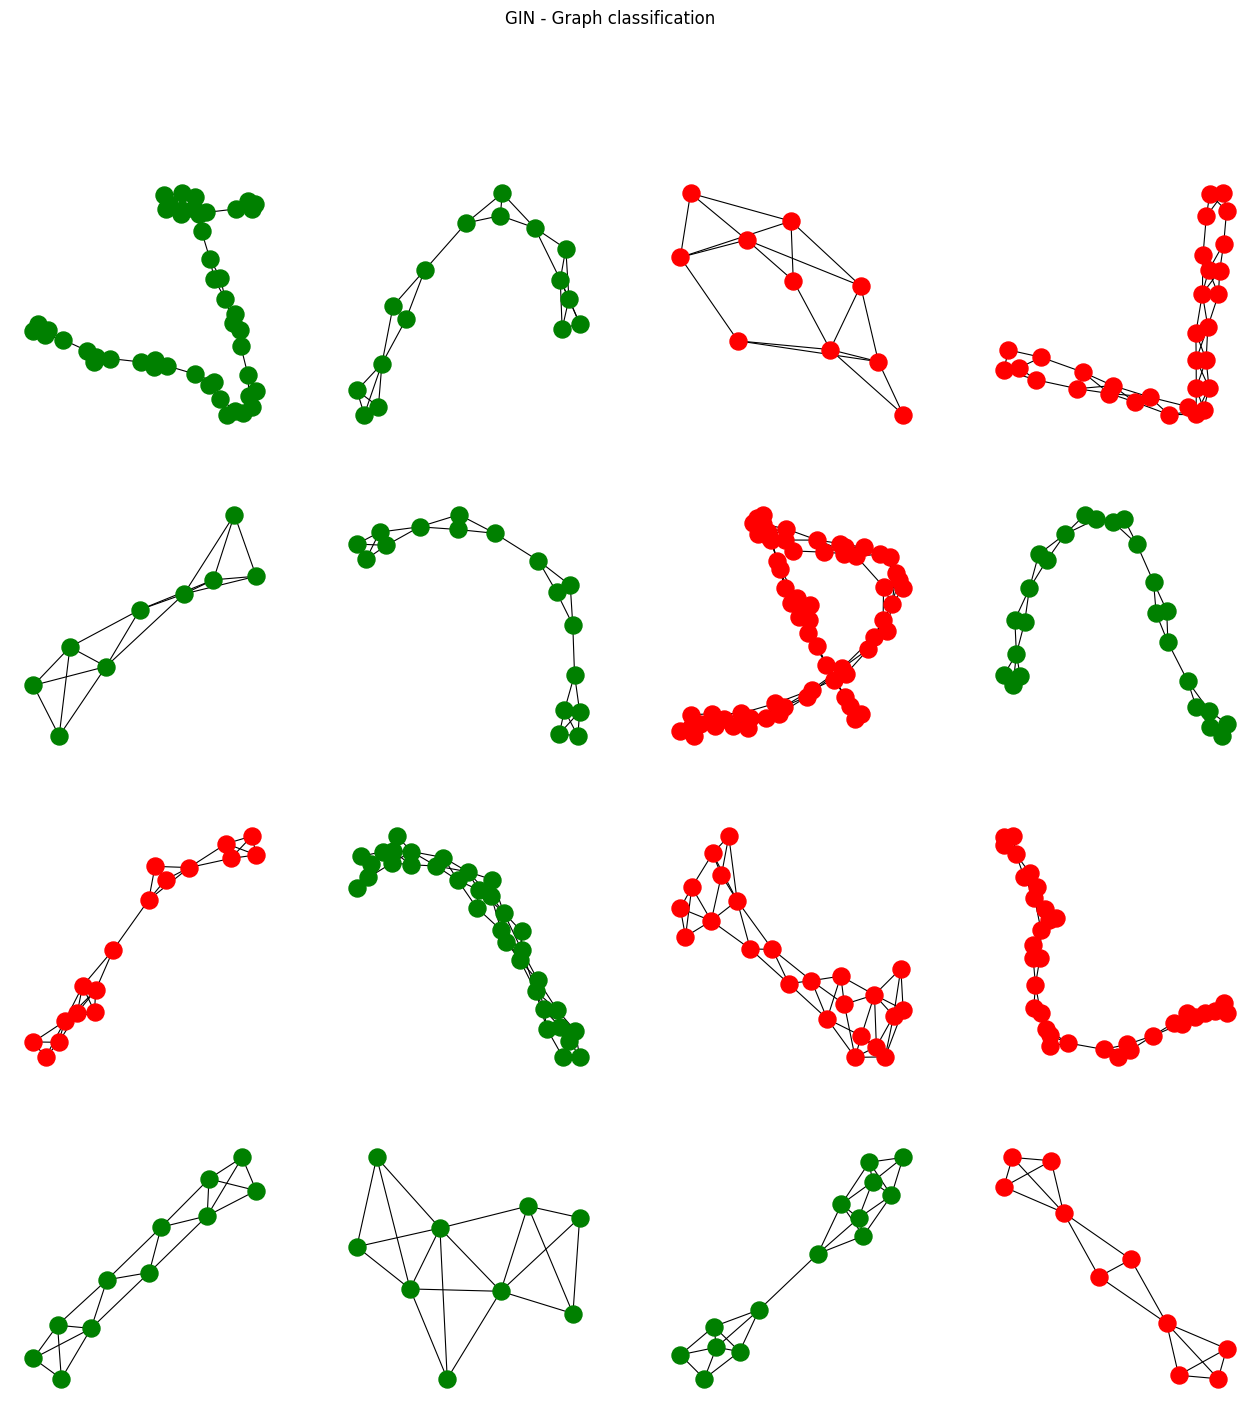

In [8]:
fig, ax = plt.subplots(4, 4, figsize=(16,16))
fig.suptitle('GIN - Graph classification')

for i, data in enumerate(dataset[1113-16:]):
    # Calculate color (green if correct, red otherwise)
    _, out = gin(data.x, data.edge_index, data.batch)
    color = "green" if out.argmax(dim=1) == data.y else "red"

    # Plot graph
    ix = np.unravel_index(i, ax.shape)
    ax[ix].axis('off')
    G = to_networkx(dataset[i], to_undirected=True)
    nx.draw_networkx(G,
                    pos=nx.spring_layout(G, seed=0),
                    with_labels=False,
                    node_size=150,
                    node_color=color,
                    width=0.8,
                    ax=ax[ix]
                    )

# Ensemble learning

In [9]:
gcn.eval()
gin.eval()
acc_gcn = 0
acc_gin = 0
acc = 0

for data in test_loader:
    # Get classifications
    _, out_gcn = gcn(data.x, data.edge_index, data.batch)
    _, out_gin = gin(data.x, data.edge_index, data.batch)
    out = (out_gcn + out_gin)/2

    # Calculate accuracy scores
    acc_gcn += accuracy(out_gcn.argmax(dim=1), data.y) / len(test_loader)
    acc_gin += accuracy(out_gin.argmax(dim=1), data.y) / len(test_loader)
    acc += accuracy(out.argmax(dim=1), data.y) / len(test_loader)

# Print results
print(f'GCN accuracy:     {acc_gcn*100:.2f}%')
print(f'GIN accuracy:     {acc_gin*100:.2f}%')
print(f'GCN+GIN accuracy: {acc*100:.2f}%')

GCN accuracy:     62.76%
GIN accuracy:     67.71%
GCN+GIN accuracy: 67.97%


## Challenge Tasks

### Task 1: Dataset Exploration

1. **Load the REDDIT-BINARY Dataset**: Use PyTorch Geometric's `TUDataset` class to load and inspect the dataset.
2. **Visualize Sample Graphs**: Plot a few graphs to understand their structure and distribution.

